### denoising diffusion implicit model

usamos el ddim y no el ddpm por ser más rapido de entrenar

## Data

In [11]:
import io, re, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df=pd.read_parquet("datos/minecraft.parquet")
print(device)

cuda


## Code

definimos una nueva clase embedding para añadir el token unknown, dropout para evitar sobre ajuste al entrenar con el modeo y proyeccion para ajustar el tamaño de salida del embeding, nos ayuda con las diffusion así como el promt vacío

In [12]:
def mostrar_resultados(resultados):
    """
    Muestra una lista de imágenes generadas con sus etiquetas.
    """
    plt.figure(figsize=(8, 2))
    for i, (img, label) in enumerate(resultados):
        plt.subplot(1, len(resultados), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.tight_layout()
    plt.show()

def generar_imagenes(modelo, txt_emb, prompt: str, n_samples=4, device="cuda"):
    
    modelo.eval()
    txt_emb.eval()
    with torch.no_grad():
        # Embedding condicional del texto
        cond_emb = txt_emb([prompt] * n_samples).to(device)

        # Ruido aleatorio
        x = torch.randn(n_samples, 3, 16, 16, device=device)

        #  Parámetros del modelo (difusión)
        betas = modelo.betas.to(device)
        alphas = modelo.alphas.to(device)
        alphas_cumprod = modelo.alphas_cumprod.to(device)
        timesteps = modelo.timesteps

        # generar imagenes
        for t in reversed(range(timesteps)):
            t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)
            noise_pred = modelo(x, t_tensor, cond_emb)

            beta_t = betas[t]
            alpha_t = alphas[t]
            alpha_bar_t = alphas_cumprod[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            x = (
                (1 / torch.sqrt(alpha_t))
                * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred)
                + torch.sqrt(beta_t) * noise
            )
        # normalizar
        x = (x * 0.5 + 0.5).clamp(0, 1)

        # Convertir a PIL y devolver
        results = []
        for i in range(n_samples):
            img_pil = TF.to_pil_image(x[i])
            results.append((img_pil, prompt))
    
    return results

# Dataset único (con augment opcional)
class MinecraftDataset(Dataset):
    def __init__(self, rows: List[dict], image_size=16, augment=False, transform=None):
        self.rows = rows
        self.image_size = image_size
        self.augment = augment

        if transform is None:
            self.transform = T.Compose([
                T.Resize((image_size, image_size)),
                T.ToTensor(),
                T.Normalize([0.5]*3, [0.5]*3)
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        r = self.rows[idx]
        img = Image.open(io.BytesIO(r["image"]["bytes"])).convert("RGB")
        img_t = self.transform(img)
        if self.augment and torch.rand(1).item() > 0.5:
            img_t = torch.flip(img_t, dims=[2])
        label = r["label"]
        return img_t, label


# TextEmbedding (mejorada)
class TextEmbedding(nn.Module):
    def __init__(self, vocab, embed_dim=128):
        super().__init__()
        if "unknown" not in vocab:
            vocab = vocab + ["unknown"]
        self.vocab = vocab
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.embedding = nn.Embedding(len(vocab), embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)  # fija dim de condicion
        self.dropout = nn.Dropout(0.1)

    @staticmethod
    def build_vocab(labels):
        words = set()
        for lbl in labels:
            for w in re.findall(r"\w+", lbl.lower()):
                words.add(w)
        if "unknown" not in words:
            words.add("unknown")
        return sorted(words)

    def forward(self, label_texts: List[str]):
        device = next(self.parameters()).device
        vectors = []
        for text in label_texts:
            tokens = [w for w in re.findall(r"\w+", text.lower()) if w in self.stoi]
            if not tokens:
                tokens = ["unknown"]
            idxs = torch.tensor([self.stoi[w] for w in tokens], device=device)
            emb = self.embedding(idxs).mean(dim=0)
            vectors.append(emb)
        x = torch.stack(vectors)
        x = self.proj(x)
        x = self.dropout(x)
        return x  # shape [B, embed_dim]


#### Crear Modelo

In [13]:
#incial codigo, version q parece de chat 5.0
"""# Small UNet for 16x16
def sinusoidal_time_embedding(timesteps, dim):
    # timesteps: tensor [B]
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0,1))
    return emb

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.down = nn.AvgPool2d(2)
    def forward(self, x):
        return self.down(self.conv(x))


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBlock(in_ch, out_ch)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        return self.conv(self.up(x))


class SimpleUNet(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, time_dim=128, cond_dim=128):
        super().__init__()
        # encoder
        self.inc = ConvBlock(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch*2)   # 8x8
        self.down2 = Down(base_ch*2, base_ch*4) # 4x4

        # bottleneck
        self.bot = ConvBlock(base_ch*4, base_ch*4)

        # decoder
        self.up2 = Up(base_ch*4, base_ch*2)     # 8x8
        self.up1 = Up(base_ch*2, base_ch)       # 16x16

        self.out_conv = nn.Sequential(
            nn.Conv2d(base_ch, in_ch, 1),
        )

        # time + cond projections (para FiLM)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, base_ch*4),
            nn.SiLU(),
            nn.Linear(base_ch*4, base_ch*4)
        )
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, base_ch*4*2),  # produce scale & shift channels
            nn.SiLU()
        )

    def forward(self, x, t, cond):
        # x: [B,3,16,16], t: [B], cond: [B,cond_dim]
        B = x.shape[0]
        # encoder
        x1 = self.inc(x)           # 16x16
        x2 = self.down1(x1)        # 8x8
        x3 = self.down2(x2)        # 4x4

        # time embed
        t_emb = sinusoidal_time_embedding(t, self.time_mlp[0].in_features)  # [B, time_dim]
        t_proj = self.time_mlp(t_emb)  # [B, base_ch*4]

        # cond as FiLM: produce scale & shift
        cond_params = self.cond_mlp(cond)  # [B, base_ch*4*2]
        cond_scale, cond_shift = cond_params.chunk(2, dim=-1)  # each [B, base_ch*4]

        h = x3
        # apply FiLM in bottleneck channel-wise
        # expand spatially
        cs = cond_scale.view(B, -1, 1, 1)
        sh = cond_shift.view(B, -1, 1, 1)
        tp = t_proj.view(B, -1, 1, 1)
        h = h * (1 + cs) + sh
        h = h + tp

        h = self.bot(h)
        h = self.up2(h)
        h = self.up1(h)
        out = self.out_conv(h)
        return out  # predicted noise eps


# Diffusion utilities (betas, alphas)
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)


class Diffusion:
    def __init__(self, timesteps=1000, device=device):
        self.timesteps = timesteps
        self.device = device
        betas = linear_beta_schedule(timesteps).to(device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        # x_start in [-1,1]
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1,1,1,1)
        sqrt_1m_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1,1,1,1)
        return sqrt_alpha_cumprod_t * x_start + sqrt_1m_alpha_cumprod_t * noise

    # DDIM deterministic step (sigma=0)
    def ddim_step(self, model_pred, x_t, t, t_prev):
        
        # model_pred: predicted noise (eps) at time t
        # x_t: current noised sample
        # t, t_prev: scalars ints (t>t_prev)
        # returns x_t_prev deterministically (sigma=0)
        
        a_t = self.alphas_cumprod[t]
        a_prev = self.alphas_cumprod[t_prev]
        sqrt_a_t = torch.sqrt(a_t)
        sqrt_a_prev = torch.sqrt(a_prev)
        # predicted x0
        x0_pred = (x_t - torch.sqrt(1 - a_t) * model_pred) / sqrt_a_t
        # compute x_{t_prev}
        x_prev = sqrt_a_prev * x0_pred + torch.sqrt(1 - a_prev) * model_pred
        return x_prev, x0_pred
"""

"# Small UNet for 16x16\ndef sinusoidal_time_embedding(timesteps, dim):\n    # timesteps: tensor [B]\n    half = dim // 2\n    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half).to(timesteps.device)\n    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)\n    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)\n    if dim % 2 == 1:\n        emb = F.pad(emb, (0,1))\n    return emb\n\nclass ConvBlock(nn.Module):\n    def __init__(self, in_ch, out_ch):\n        super().__init__()\n        self.net = nn.Sequential(\n            nn.Conv2d(in_ch, out_ch, 3, padding=1),\n            nn.GroupNorm(8, out_ch),\n            nn.SiLU(),\n            nn.Conv2d(out_ch, out_ch, 3, padding=1),\n            nn.GroupNorm(8, out_ch),\n            nn.SiLU(),\n        )\n    def forward(self, x):\n        return self.net(x)\n\n\nclass Down(nn.Module):\n    def __init__(self, in_ch, out_ch):\n        super().__init__()\n        self.conv = ConvBlock(in_ch,

In [14]:
# Bloques básicos
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_fc = nn.Linear(1, out_ch)
        self.cond_fc = nn.Linear(cond_dim, out_ch)
        self.norm = nn.BatchNorm2d(out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t, cond):
        h = F.silu(self.conv1(x))
        t_emb = self.time_fc(t.unsqueeze(-1)).view(t.size(0), -1, 1, 1)
        c_emb = self.cond_fc(cond).view(cond.size(0), -1, 1, 1)
        h = h + t_emb + c_emb
        h = F.silu(self.norm(self.conv2(h)))
        return h + self.skip(x)


class MiniUNet(nn.Module):
    def __init__(self, cond_dim=128, base_ch=64, timesteps=100):
        super().__init__()
        self.timesteps = timesteps
        # Parámetros de difusión (no entrenables)
        self.register_buffer("betas", torch.linspace(1e-4, 0.02, timesteps))
        self.register_buffer("alphas", 1.0 - self.betas)
        self.register_buffer("alphas_cumprod", torch.cumprod(self.alphas, dim=0))

        # encoder
        self.down1 = ResidualBlock(3, base_ch, cond_dim)
        self.down2 = ResidualBlock(base_ch, base_ch * 2, cond_dim)
        self.pool = nn.AvgPool2d(2)

        # middle
        self.mid = ResidualBlock(base_ch * 2, base_ch * 2, cond_dim)

        # decoder
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.up1 = ResidualBlock(base_ch * 2, base_ch, cond_dim)
        self.out = nn.Conv2d(base_ch, 3, 1)

    def forward(self, x, t, cond):
        # normalizar t en [0,1]
        t = t.float() / self.timesteps
        h1 = self.down1(x, t, cond)
        h2 = self.down2(self.pool(h1), t, cond)
        h_mid = self.mid(h2, t, cond)
        h_up = self.up(h_mid)
        h_up = self.up1(h_up, t, cond)
        out = self.out(h_up)
        return out


In [15]:
embed_dim = 100       # un poco más compacto, suficiente
timesteps = 200       # más de pasos mejora la calidad
ch_base = 96          # modelo más grande 

batch_size = 32
lr = 1e-4
num_epochs = 1000   

In [16]:
# Construir vocabulario
all_labels = df["label"].tolist()
cleaned_labels = [re.sub(r"\d+", "", lbl).strip() for lbl in all_labels]
all_labels = list(set(cleaned_labels))
vocab = TextEmbedding.build_vocab(all_labels)

print(f" Vocabulario generado con {len(vocab)} palabras únicas:")
# print(vocab)

# Dataset y DataLoader
dataset = MinecraftDataset(df.to_dict("records"), image_size=16, augment=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


 Vocabulario generado con 352 palabras únicas:


#### Entrenamiento

In [17]:
# MODELOS 
txt_emb = TextEmbedding(vocab, embed_dim=embed_dim).to(device)
model = MiniUNet(cond_dim=embed_dim, base_ch=ch_base, timesteps=timesteps).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Epoch 50/3000 | Loss: 0.1323


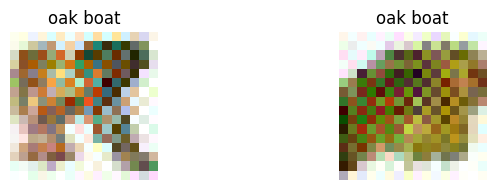

Epoch 100/3000 | Loss: 0.1284


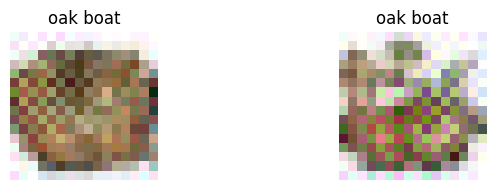

Epoch 150/3000 | Loss: 0.1302


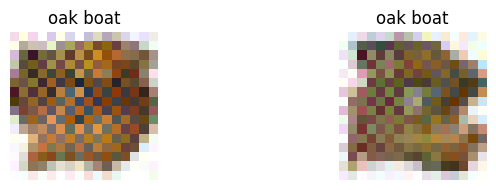

Epoch 200/3000 | Loss: 0.1143


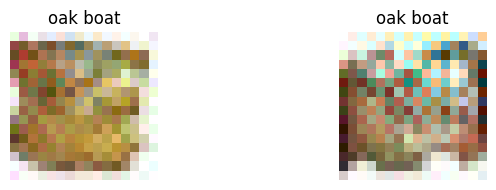

Epoch 250/3000 | Loss: 0.1039


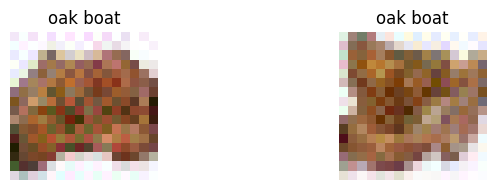

Epoch 300/3000 | Loss: 0.1094


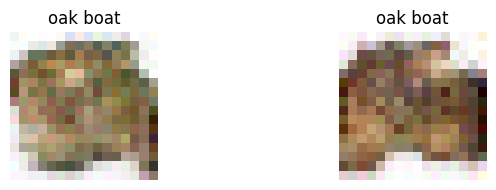

Epoch 350/3000 | Loss: 0.1137


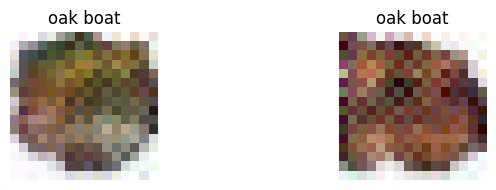

Epoch 400/3000 | Loss: 0.1087


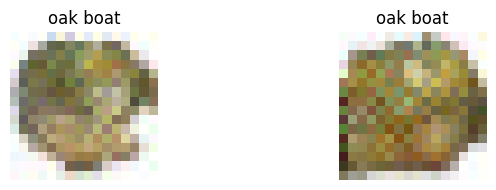

Epoch 450/3000 | Loss: 0.1059


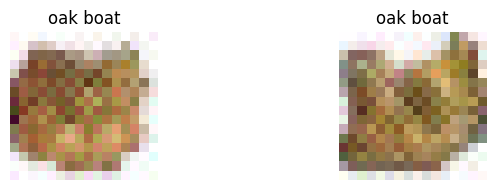

Epoch 500/3000 | Loss: 0.0996


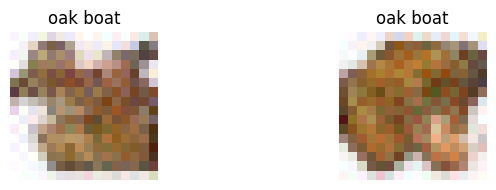

Epoch 550/3000 | Loss: 0.1091


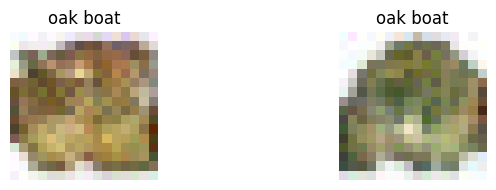

Epoch 600/3000 | Loss: 0.0963


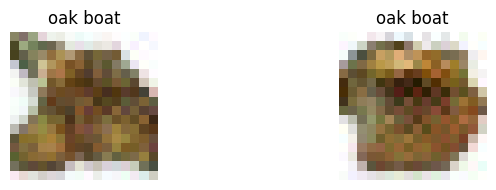

Epoch 650/3000 | Loss: 0.1075


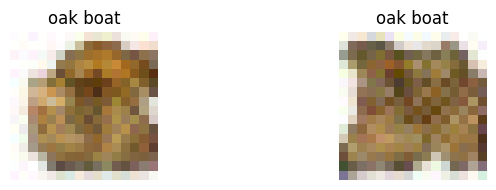

Epoch 700/3000 | Loss: 0.0987


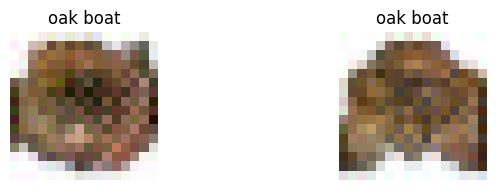

Epoch 750/3000 | Loss: 0.0904


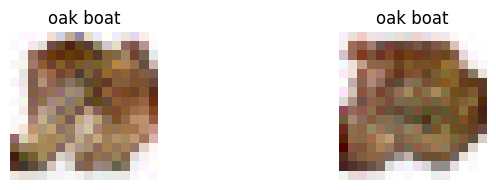

Epoch 800/3000 | Loss: 0.0913


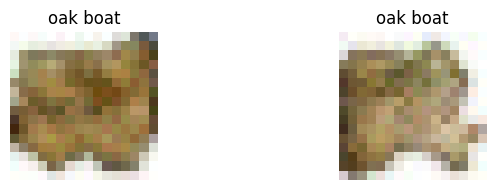

Epoch 850/3000 | Loss: 0.0865


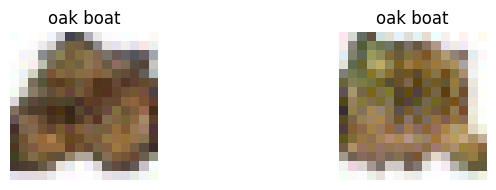

Epoch 900/3000 | Loss: 0.0800


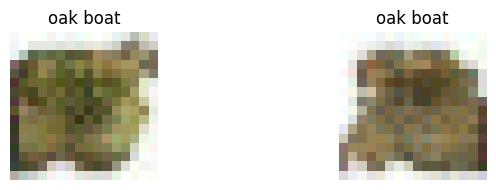

Epoch 950/3000 | Loss: 0.0886


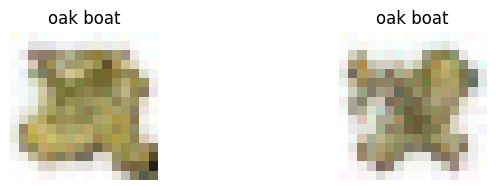

Epoch 1000/3000 | Loss: 0.0843


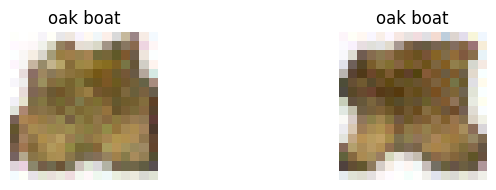

Epoch 1050/3000 | Loss: 0.0786


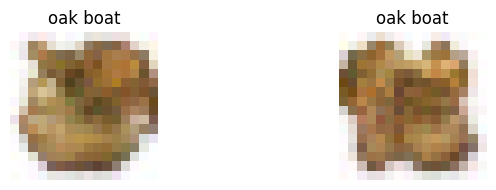

Epoch 1100/3000 | Loss: 0.0812


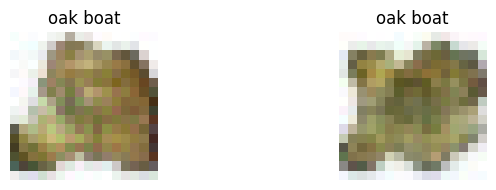

Epoch 1150/3000 | Loss: 0.0754


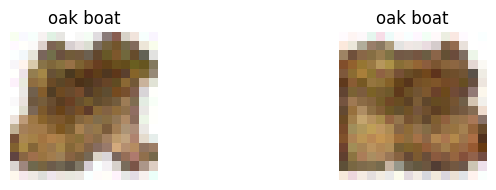

Epoch 1200/3000 | Loss: 0.0929


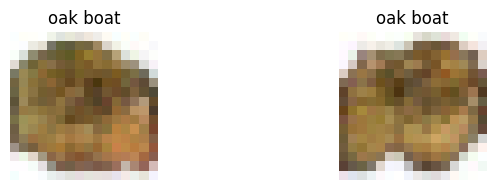

Epoch 1250/3000 | Loss: 0.0779


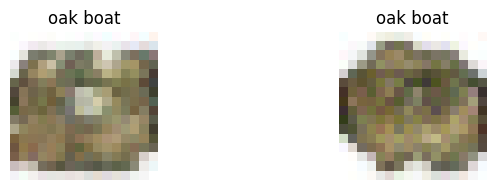

Epoch 1300/3000 | Loss: 0.0760


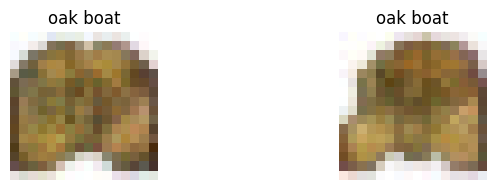

Epoch 1350/3000 | Loss: 0.0863


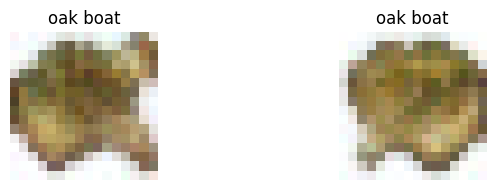

Epoch 1400/3000 | Loss: 0.0734


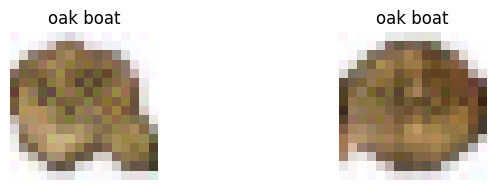

Epoch 1450/3000 | Loss: 0.0757


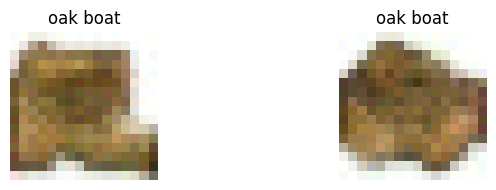

Epoch 1500/3000 | Loss: 0.0729


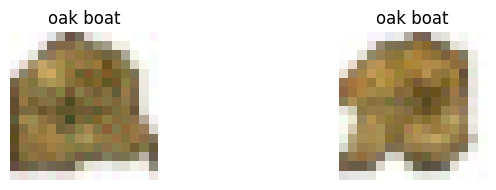

Epoch 1550/3000 | Loss: 0.0762


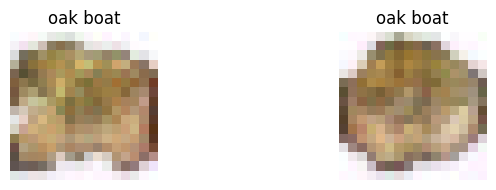

Epoch 1600/3000 | Loss: 0.0622


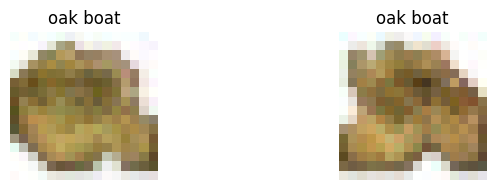

Epoch 1650/3000 | Loss: 0.0759


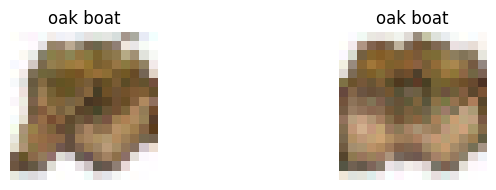

Epoch 1700/3000 | Loss: 0.0675


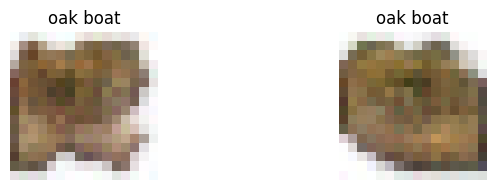

Epoch 1750/3000 | Loss: 0.0814


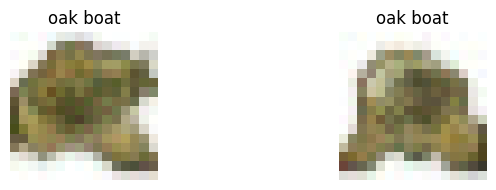

Epoch 1800/3000 | Loss: 0.0656


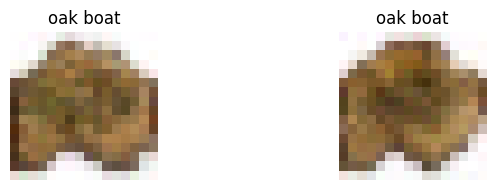

Epoch 1850/3000 | Loss: 0.0722


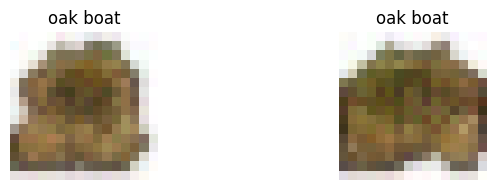

Epoch 1900/3000 | Loss: 0.0658


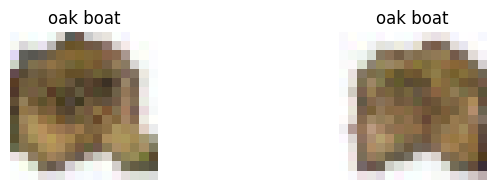

Epoch 1950/3000 | Loss: 0.0650


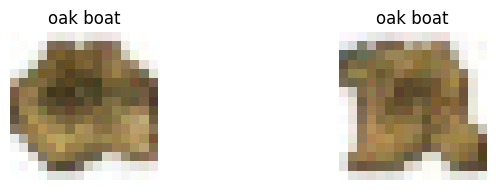

Epoch 2000/3000 | Loss: 0.0740


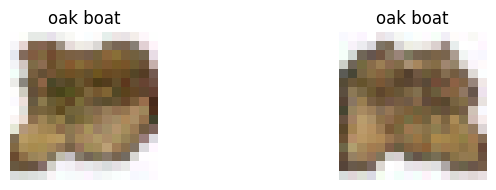

Epoch 2050/3000 | Loss: 0.0709


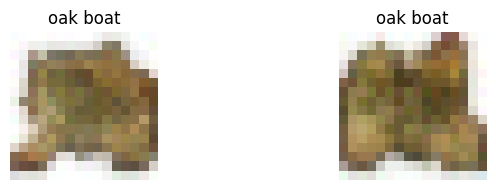

Epoch 2100/3000 | Loss: 0.0657


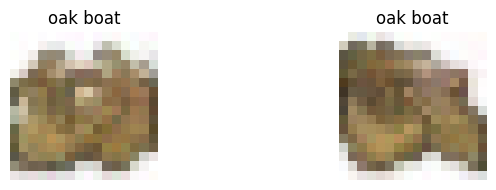

Epoch 2150/3000 | Loss: 0.0631


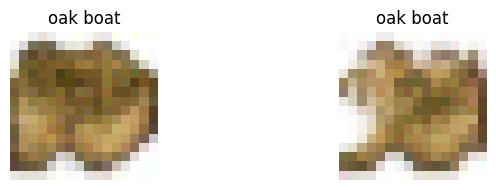

Epoch 2200/3000 | Loss: 0.0652


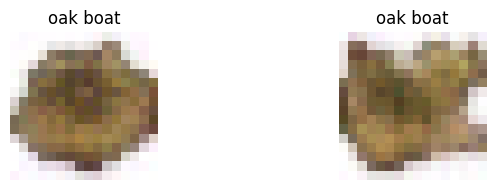

Epoch 2250/3000 | Loss: 0.0657


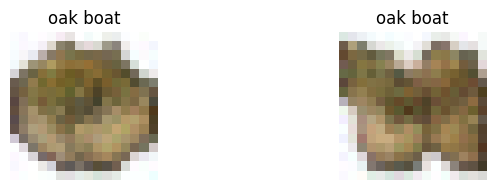

Epoch 2300/3000 | Loss: 0.0622


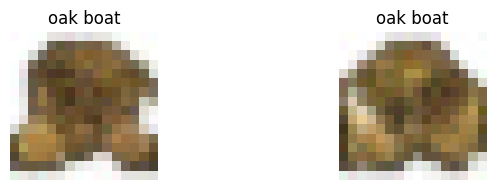

Epoch 2350/3000 | Loss: 0.0672


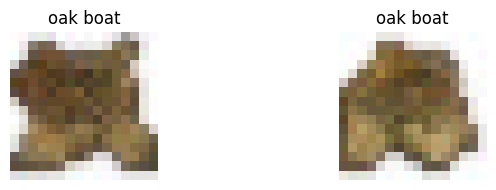

Epoch 2400/3000 | Loss: 0.0682


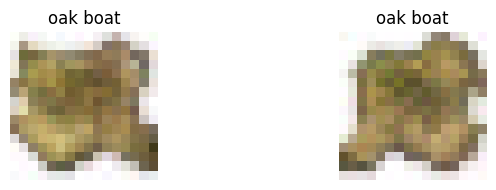

Epoch 2450/3000 | Loss: 0.0579


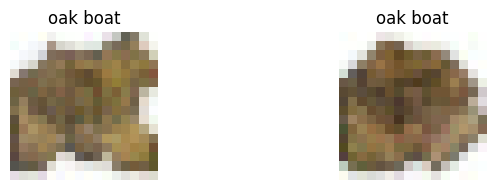

Epoch 2500/3000 | Loss: 0.0661


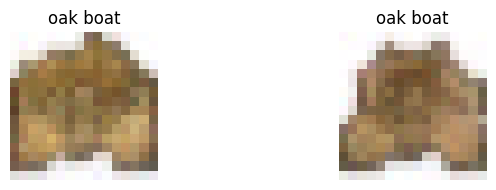

Epoch 2550/3000 | Loss: 0.0668


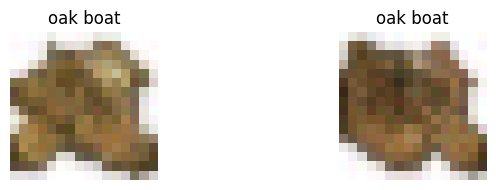

Epoch 2600/3000 | Loss: 0.0586


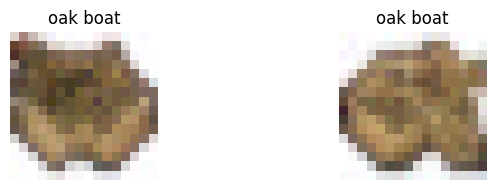

Epoch 2650/3000 | Loss: 0.0635


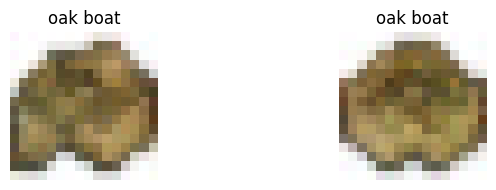

Epoch 2700/3000 | Loss: 0.0708


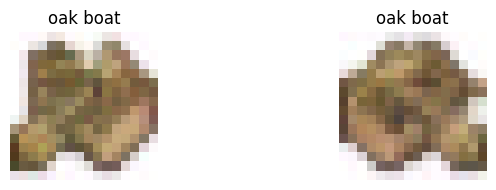

Epoch 2750/3000 | Loss: 0.0668


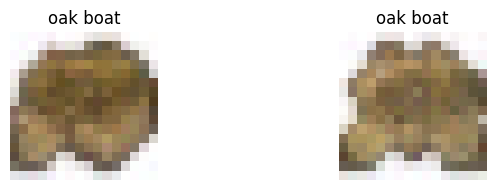

Epoch 2800/3000 | Loss: 0.0620


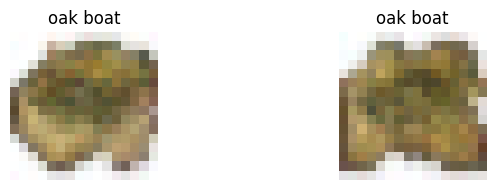

Epoch 2850/3000 | Loss: 0.0630


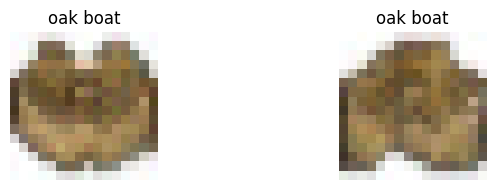

Epoch 2900/3000 | Loss: 0.0591


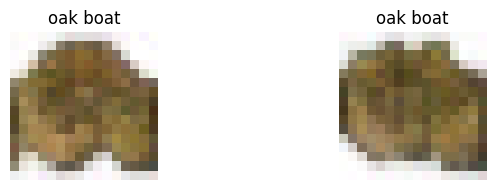

Epoch 2950/3000 | Loss: 0.0590


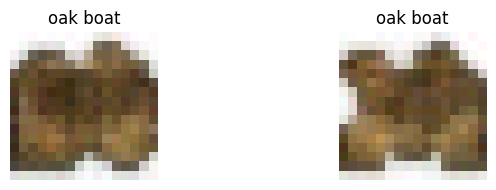

Epoch 3000/3000 | Loss: 0.0674


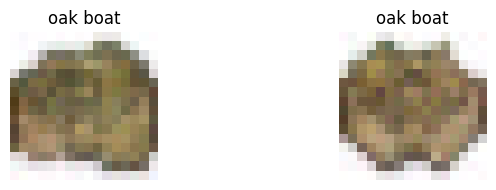

In [19]:
# entrenamiento funcion primera version

num_epochs = 3000

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        cond = txt_emb(labels).to(device)

        # sample random timesteps y ruido
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)
        noise = torch.randn_like(imgs)

        alpha_bar_t = model.alphas_cumprod[t].view(-1, 1, 1, 1)
        x_t = torch.sqrt(alpha_bar_t) * imgs + torch.sqrt(1 - alpha_bar_t) * noise
        
        noise_pred = model(x_t, t, cond)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # =========================================================
    # LOGGING
    # =========================================================   
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs} | Loss: {total_loss / len(dataloader):.4f}")

        # Generar una imagen de ejemplo condicional
        test_prompt = "oak boat"
        imgs_gen = generar_imagenes(model, txt_emb, test_prompt, n_samples=2)
        mostrar_resultados(imgs_gen)
        

#### resultados

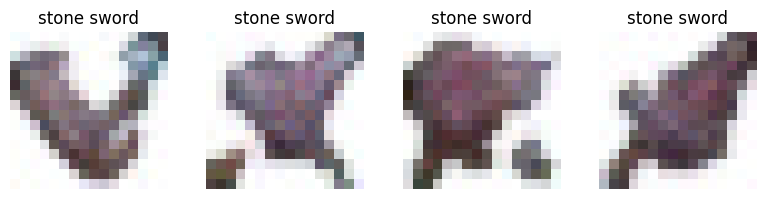

In [34]:
prompt = "stone sword"
imgs = generar_imagenes(model, txt_emb, prompt)
mostrar_resultados(imgs)


#### Guardar modelos

In [20]:
# GUARDAR MODELOS
import os
import torch

version = "v1"
save_dir = f"./DDIM/{version}"
os.makedirs(save_dir, exist_ok=True)


torch.save(model.state_dict(), os.path.join(save_dir, "diffusion_model.pth"))
torch.save(txt_emb.state_dict(), os.path.join(save_dir, "text_embedding.pth"))

# guardamos hiperparámetros y vocabulario
metadata = {
    "embed_dim": embed_dim,
    "timesteps": timesteps,
    "ch_base": ch_base,
    "vocab": txt_emb.vocab,}

torch.save(metadata, os.path.join(save_dir, "metadata.pth"))

print(f" Modelos y metadatos guardados en: {save_dir}")



 Modelos y metadatos guardados en: ./DDIM/v1
